In [2]:
import bench_lib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bench_plot_lib as plot_lib


import importlib
importlib.reload(bench_lib)
importlib.reload(plot_lib)

GiB = 2**30

SYS_NAME = "cache_ext"
FIGURES_DIR = "figures/"
iops_select_fn = lambda r: r["jobs"][0]["read"]["iops"]
leveldb_throughput_avg_select_fn = lambda r: r["throughput_avg"]
leveldb_read_throughput_avg_select_fn = lambda r: r["read_throughput_avg"]
leveldb_scan_throughput_avg_select_fn = lambda r: r["scan_throughput_avg"]
leveldb_latency_p99_select_fn = lambda r: r["latency_p99"] / 10**6 if r["latency_p99"] != 0 else r["scan_latency_p99"] / 10**6
leveldb_read_latency_p99_select_fn = lambda r: r["read_latency_p99"] / 10**6
leveldb_scan_latency_p99_select_fn = lambda r: r["scan_latency_p99"] / 10**6

def filter_cgroup_results(results, cgroup_name):
    return [r for r in results if r.config["cgroup_name"] == cgroup_name]

def filter_cache_ext_results(results):
    return filter_cgroup_results(results, bench_lib.DEFAULT_CACHE_EXT_CGROUP)

def add_config_field(results, key, value):
    for r in results:
        if key not in r.config:
            r.config[key] = value


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


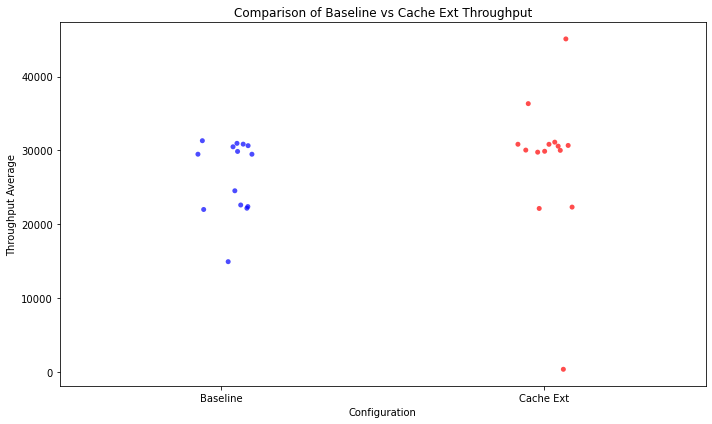

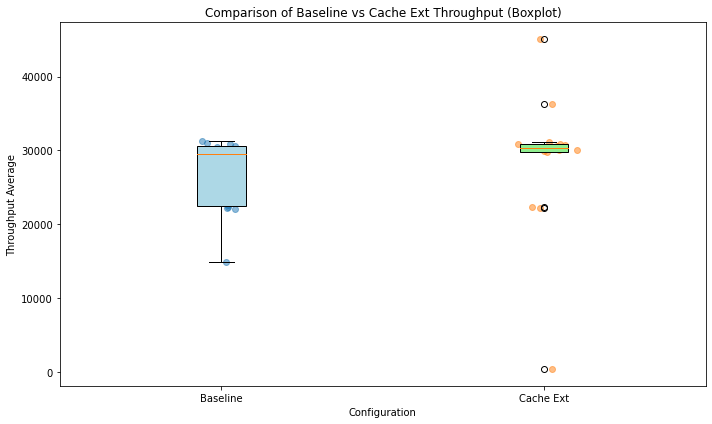

Baseline Throughput Average: 26549.80
Cache Ext Throughput Average: 28567.96
Diff 7.60%


In [26]:
io_trace_results = bench_lib.parse_results_file("io_trace_results_test_lru_vm5.json", bench_lib.BenchResults)

config_matches = [
    {
        "name": "iotrace_benchmark",
        "benchmark": "trace_cluster1_16TB_20240115_data-00052-of-00100"
    }
]

config_matches = bench_lib.add_config_option("cgroup_size", [15*GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)

baseline_config = config_matches[0]
cache_ext_config = config_matches[1]

throughput_avg_select_fn = lambda r: r.results["throughput_avg"]
read_throughput_avg_select_fn = lambda r: r.results["read_throughput_avg"]
insert_throughput_avg_select_fn = lambda r: r.results["insert_throughput_avg"]

baseline_results = map(insert_throughput_avg_select_fn, bench_lib.results_select(io_trace_results, baseline_config))
cache_ext_results = map(insert_throughput_avg_select_fn, bench_lib.results_select(io_trace_results, cache_ext_config))

# Convert to lists if they're not already
baseline_results = list(baseline_results)
cache_ext_results = list(cache_ext_results)

# Create a stripplot
plt.figure(figsize=(10, 6))

# Combine data and create labels
all_data = baseline_results + cache_ext_results
labels = ['Baseline'] * len(baseline_results) + ['Cache Ext'] * len(cache_ext_results)

# Create the stripplot
sns.stripplot(x=labels, y=all_data, jitter=True, size=5, palette={'Baseline': 'blue', 'Cache Ext': 'red'}, alpha=0.7)

plt.xlabel('Configuration')
plt.ylabel('Throughput Average')
plt.title('Comparison of Baseline vs Cache Ext Throughput')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Create a boxplot
plt.figure(figsize=(10, 6))

# Prepare data for boxplot
data = [baseline_results, cache_ext_results]
labels = ['Baseline', 'Cache Ext']

# Create the boxplot
box_plot = plt.boxplot(data, labels=labels, patch_artist=True)

# Customize boxplot colors
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)

plt.xlabel('Configuration')
plt.ylabel('Throughput Average')
plt.title('Comparison of Baseline vs Cache Ext Throughput (Boxplot)')

# Add individual data points
for i, d in enumerate(data):
    y = d
    x = np.random.normal(i + 1, 0.04, len(y))
    plt.scatter(x, y, alpha=0.5)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print average values for throughput
print("Baseline Throughput Average: {:.2f}".format(np.mean(baseline_results)))
print("Cache Ext Throughput Average: {:.2f}".format(np.mean(cache_ext_results)))
# Diff %
diff_pct = (np.mean(cache_ext_results) - np.mean(baseline_results)) / np.mean(baseline_results) * 100
print("Diff %.2f%%" % diff_pct)


## Twitter Traces

In [59]:
# YCSB results

clusters = [17, 18, 24, 34, 52]
results = []
mglru_results = []
for cluster in clusters:
    results += bench_lib.parse_results_file("results/cache_ext_twitter_traces_%d.json" % cluster, bench_lib.BenchResults)
    mglru_results += bench_lib.parse_results_file("results/baseline_mglru_twitter_traces_%d.json" % cluster, bench_lib.BenchResults)

cache_ext_results = filter_cache_ext_results(results)
baseline_results = filter_cgroup_results(results, bench_lib.DEFAULT_BASELINE_CGROUP)

add_config_field(cache_ext_results, "mglru", False)
add_config_field(baseline_results, "mglru", False)
add_config_field(mglru_results, "mglru", True)


config_matches = [
    {
        "name": "leveldb_twitter_trace_benchmark",
    }
]

config_matches = bench_lib.add_config_option("cgroup_size_pct", [10], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)

baseline_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP]
cache_ext_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP]
baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)

cache_ext_matches = bench_lib.add_config_option(
    "policy_loader",
    [
        "cache_ext_lhd.out",
        "cache_ext_s3fifo.out",
        "page_cache_ext_sampling.out",
    ],
    cache_ext_matches,
)

# new_config_matches = []
# for config in config_matches:
#     if config["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP:
#         new_config = config.copy()
#         new_config_matches.append(new_config)
#     else:
#         # for policy_loader in ["cache_ext_s3fifo.out"]:
#         for policy_loader in ["cache_ext_s3fifo.out", "page_cache_ext_sampling.out", "cache_ext_lhd.out"]:
#             new_config = config.copy()
#             new_config["policy_loader"] = policy_loader
#             new_config_matches.append(new_config)
# config_matches = new_config_matches

config_matches = baseline_matches + cache_ext_matches

bench_types = ["twitter_cluster%d_bench" % cluster for cluster in clusters]
bench_type_to_group = {"twitter_cluster%d_bench" % cluster: "Cluster %d" % cluster for cluster in clusters}


# baseline_mglru_results = bench_lib.parse_results_file("results/baseline_mglru_ycsb_results.json", bench_lib.BenchResults)
# cache_ext_ycsb_results = filter_cache_ext_results(ycsb_results)
# baseline_ycsb_results = filter_cgroup_results(ycsb_results, bench_lib.DEFAULT_BASELINE_CGROUP)

# add_config_field(baseline_ycsb_results, "mglru", False)
# add_config_field(baseline_mglru_results, "mglru", True)
# add_config_field(cache_ext_ycsb_results, "mglru", False)

# ycsb_results = baseline_ycsb_results + cache_ext_ycsb_results + baseline_mglru_results

# config_matches = [
#     {
#         "name": "leveldb_benchmark",
#     }
# ]
# config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
# config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)

# print(config_matches)

# baseline_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP]
# cache_ext_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP]
# baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)

def name_func(config):
    if config["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP:
        if config["mglru"]:
            return "MGLRU (Linux)"
        else:
            return "Default (Linux)"
        # return "Baseline (%d%% cache)" % config["cgroup_size_pct"]
    elif "s3fifo" in config["policy_loader"].lower():
        return "S3-FIFO (cache_ext)"
    elif "sampling" in config["policy_loader"].lower():
        return "LFU (cache_ext)"
    elif "lhd" in config["policy_loader"].lower():
        return "LHD (cache_ext)"

colors = plt.colormaps['Dark2'].colors

plot_lib.bench_plot_groupped_results(
    config_matches,
    results + mglru_results,
    colors=colors[:5],
    #["darkblue", "maroon", "darkolivegreen", "goldenrod", "red"],
    #colors=["salmon", "limegreen", "maroon", "darkolivegreen"],
    #colors=["salmon", "limegreen", "gold", "maroon", "darkolivegreen", "goldenrod"],
    bench_types=bench_types,
    bench_type_to_group=bench_type_to_group,
    filename=FIGURES_DIR + "leveldb_twitter_traces_throughput.pdf",
    bar_width=0.5,
    show_measurements=True,
    y_label="Throughput (ops/sec)",
    name_func=name_func,
    result_select_fn=leveldb_throughput_avg_select_fn,
    normalize_per_group=False,
    legend_loc="best",
    label_fontsize=20,
    fontsize=12,
    measurement_fontsize=10,
    measurement_offset=2000,
    ylimit=130000,
)


{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster17_bench'}
[84199.16, 84541.94, 84160.75]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster18_bench'}
[80767.09, 77341.95, 79763.0]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster24_bench'}
[61922.71, 61900.07, 61950.32]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster34_bench'}
[15689.06, 15837.53, 15708.39]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'twitter_cluster52_bench'}
[39044.51, 38797.87, 39037.43]
{'name': 'leveldb_twitter_trace_benchmark', 'cgroup_size_pct': 10, 'cgr

<Figure size 432x288 with 0 Axes>

## Filesearch Benchmark

In [5]:
def make_name(config) -> str:
    DEFAULT_CACHE_EXT_CGROUP = "cache_ext_test"
    DEFAULT_BASELINE_CGROUP = "baseline_test"
    if config["cgroup_name"] == DEFAULT_BASELINE_CGROUP:
        mglru = config.get("mglru", False)
        if mglru:
            return "MGLRU (Linux)"
        return "Default (Linux)"
    elif config["cgroup_name"] == DEFAULT_CACHE_EXT_CGROUP:
        return "MRU (cache_ext)"
    return "<unknown>"

baseline_filesearch_results = bench_lib.parse_results_file("results/baseline_filesearch_results.json", bench_lib.BenchResults)
baseline_mglru_filesearch_results = bench_lib.parse_results_file("results/baseline_mglru_filesearch_results.json", bench_lib.BenchResults)
cache_ext_filesearch_results = bench_lib.parse_results_file("results/filesearch_results.json", bench_lib.BenchResults)
cache_ext_filesearch_results = filter_cache_ext_results(cache_ext_filesearch_results)

add_config_field(baseline_filesearch_results, "mglru", False)
add_config_field(baseline_mglru_filesearch_results, "mglru", True)
add_config_field(cache_ext_filesearch_results, "mglru", False)

filesearch_results = baseline_filesearch_results + cache_ext_filesearch_results + baseline_mglru_filesearch_results

config_matches = [{"name": "filesearch_benchmark"}]
config_matches = bench_lib.add_config_option("cgroup_size", [1* GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)
# Add mglru option for baseline only
# Add mglru option for baseline only
baseline_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP]
cache_ext_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP]
baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)
config_matches = baseline_matches + cache_ext_matches

runtime_select_fn = lambda r: r["runtime_sec"]

colors = plt.colormaps['Dark2'].colors

plot_lib.bench_plot_groupped_results(
    config_matches,
    filesearch_results,
    y_label="Runtime (s)",
    show_measurements=False,
    colors=colors[0:3], #["salmon", "maroon", "limegreen"],
    bench_types=["filesearch"],
    result_select_fn=runtime_select_fn,
    bench_type_to_group={"filesearch": "File Search"},
    filename=FIGURES_DIR + "filesearch_results.pdf",
    label_fontsize=20,
    fontsize=20,
    legend_fontsize=16,
    ylimit=50,
    name_func=make_name,
)

{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'filesearch'}
[45.02097177505493]
{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'baseline_test', 'mglru': True, 'benchmark': 'filesearch'}
[44.225725412368774]
{'name': 'filesearch_benchmark', 'cgroup_size': 1073741824, 'cgroup_name': 'cache_ext_test', 'benchmark': 'filesearch'}
[24.680588006973267]
[[45.02097177505493], [44.225725412368774], [24.680588006973267]]
[-1.  0.  1.]
[-1.]
[0.]
[1.]


<Figure size 432x288 with 0 Axes>

In [21]:
colors = plt.colormaps['Dark2'].colors
colors[0:3]

((0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254))

## Generic Policies

In [99]:
# YCSB results

def make_name(config) -> str:
    DEFAULT_CACHE_EXT_CGROUP = "cache_ext_test"
    DEFAULT_BASELINE_CGROUP = "baseline_test"
    if config["cgroup_name"] == DEFAULT_BASELINE_CGROUP:
        mglru = config.get("mglru", False)
        if mglru:
            return "MGLRU (Linux)"
        return "Default (Linux)"
    elif config["cgroup_name"] == DEFAULT_CACHE_EXT_CGROUP:
        if "s3fifo" in config["policy_loader"]:
            return "S3-FIFO (cache_ext)"
        elif "sampling" in config["policy_loader"]:
            return "LFU (cache_ext)"
        elif "lhd" in config["policy_loader"]:
            return "LHD (cache_ext)"
        elif "fifo" in config["policy_loader"]:
            return "FIFO (cache_ext)"
        elif "mru" in config["policy_loader"]:
            return "MRU (cache_ext)"
    return "<unknown>"

ycsb_results = bench_lib.parse_results_file("results/cache_ext_ycsb_results_w_latency.json", bench_lib.BenchResults)

baseline_mglru_results = bench_lib.parse_results_file("results/baseline_mglru_ycsb_results.json", bench_lib.BenchResults)
cache_ext_ycsb_results = filter_cache_ext_results(ycsb_results)
baseline_ycsb_results = filter_cgroup_results(ycsb_results, bench_lib.DEFAULT_BASELINE_CGROUP)

add_config_field(baseline_ycsb_results, "mglru", False)
add_config_field(baseline_mglru_results, "mglru", True)
add_config_field(cache_ext_ycsb_results, "mglru", False)

ycsb_results = baseline_ycsb_results + cache_ext_ycsb_results + baseline_mglru_results

config_matches = [
    {
        "name": "leveldb_benchmark",
    }
]
config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)

print(config_matches)

baseline_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP]
cache_ext_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP]
baseline_matches = bench_lib.add_config_option("mglru", [False, True], baseline_matches)
cache_ext_matches = bench_lib.add_config_option(
    "policy_loader",
    [
        "cache_ext_lhd.out",
        "cache_ext_s3fifo.out",
        "page_cache_ext_sampling.out",
        "cache_ext_fifo.out",
        "page_cache_ext_mru.out",
    ],
    cache_ext_matches,
)


print(cache_ext_matches)

#lhd_matches = [cm for cm in cache_ext_matches if "lhd" in cm["policy_loader"]]
#s3fifo_matches = [cm for cm in cache_ext_matches if "s3fifo" in cm["policy_loader"]]
sampling_matches = [cm for cm in cache_ext_matches if "sampling" in cm["policy_loader"]]
#mru_matches = [cm for cm in cache_ext_matches if "mru" in cm["policy_loader"]]
#fifo_matches = [cm for cm in cache_ext_matches if "_fifo" in cm["policy_loader"]]

matches = baseline_matches + sampling_matches # + lhd_matches + s3fifo_matches + mru_matches + fifo_matches

plot_lib.leveldb_plot_ycsb_results(
    matches,
    ycsb_results,
    name_func=make_name,
    colors=colors[:3], #"salmon", "maroon", "limegreen", "goldenrod"],
    bench_types=["ycsb_a", "ycsb_b", "ycsb_c", "ycsb_d", "ycsb_e", "ycsb_f", "uniform", "uniform_read_write"],
        #["uniform", "uniform_read_write"],
    filename=FIGURES_DIR + "leveldb_ycsb_throughput.pdf",
    bar_width=1.1,
    show_measurements=True,
    result_select_fn=leveldb_throughput_avg_select_fn,
    ylimit=30000,
    text_center_list=[3],
    measurement_offset=500,
    fontsize=11,
    label_fontsize=18,
)

plot_lib.leveldb_plot_ycsb_results(
    matches,
    ycsb_results,
    colors=colors[:3],
    name_func=make_name,
    bench_types=["ycsb_a", "ycsb_b", "ycsb_c", "ycsb_d", "ycsb_e", "ycsb_f", "uniform", "uniform_read_write"],
    filename=FIGURES_DIR + "leveldb_ycsb_latency.pdf",
    bar_width=1,
    result_select_fn=leveldb_latency_p99_select_fn,
    show_measurements=False,
    y_label="P99 Latency (ms)",
    fontsize=11,
    label_fontsize=18,
)

[{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test'}]
[{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_lhd.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_s3fifo.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'page_cache_ext_sampling.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'cache_ext_fifo.out'}, {'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'policy_loader': 'page_cache_ext_mru.out'}]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'benchmark': 'ycsb_a'}
[13823.79, 13788.

<Figure size 432x288 with 0 Axes>

## Application-Informed Policy

In [7]:
# Mixed GET-SCAN results

baseline_get_scan_results = bench_lib.parse_results_file("results/baseline_get_scan_results.json", bench_lib.BenchResults)
baseline_mglru_get_scan_results = bench_lib.parse_results_file("results/baseline_mglru_get_scan_results.json", bench_lib.BenchResults)
cache_ext_get_scan_results = bench_lib.parse_results_file("results/cache_ext_get_scan_results.json", bench_lib.BenchResults)
cache_ext_get_scan_results = filter_cache_ext_results(cache_ext_get_scan_results)

add_config_field(baseline_get_scan_results, "mglru", False)
add_config_field(baseline_mglru_get_scan_results, "mglru", True)
add_config_field(cache_ext_get_scan_results, "mglru", False)
get_scan_results = baseline_get_scan_results + cache_ext_get_scan_results + baseline_mglru_get_scan_results

config_matches = [
    {
        "name": "leveldb_benchmark",
    }
]

config_matches = bench_lib.add_config_option("cgroup_size", [10 * GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)

# Get the baseline config and generate two more:
# - One with "fadvise": "NOREUSE"
# - One with "fadvise": "DONTNEED"
# - One with "fadvise": "SEQUENTIAL"

baseline_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_BASELINE_CGROUP]
cache_ext_matches = [cm for cm in config_matches if cm["cgroup_name"] == bench_lib.DEFAULT_CACHE_EXT_CGROUP]

baseline_matches = bench_lib.add_config_option("mglru", [False], baseline_matches)
baseline_matches = bench_lib.add_config_option("fadvise", ["", "NOREUSE", "DONTNEED", "SEQUENTIAL"], baseline_matches)
baseline_mglru_match = baseline_matches[0].copy()
baseline_mglru_match["mglru"] = True
baseline_matches.append(baseline_mglru_match)

config_matches = baseline_matches + cache_ext_matches


baseline_idx = 0
cache_ext_idx = -1

config_matches[baseline_idx]["iteration"] = 1
# throughput_baseline = leveldb_read_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# latency_baseline = leveldb_read_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# throughput_cache_ext = leveldb_read_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)
# latency_cache_ext = leveldb_read_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)

# Get averages from results
throughput_baseline = np.mean([leveldb_read_throughput_avg_select_fn(r.results) for r in bench_lib.results_select(get_scan_results, config_matches[baseline_idx])])
latency_baseline = np.mean([leveldb_read_latency_p99_select_fn(r.results) for r in bench_lib.results_select(get_scan_results, config_matches[baseline_idx])])
throughput_cache_ext = np.mean([leveldb_read_throughput_avg_select_fn(r.results) for r in bench_lib.results_select(get_scan_results, config_matches[cache_ext_idx])])
latency_cache_ext = np.mean([leveldb_read_latency_p99_select_fn(r.results) for r in bench_lib.results_select(get_scan_results, config_matches[cache_ext_idx])])

# Calculate improvement over baseline
throughput_improvement = throughput_cache_ext / throughput_baseline
latency_improvement = (latency_baseline - latency_cache_ext) / latency_baseline * 100
print(f"Throughput improvement: {throughput_improvement:.2f}x")
print(f"Latency reduction: {latency_improvement:.2f}%")
print("Latency: baseline %.2fms, cache_ext %.2fms" % (latency_baseline, latency_cache_ext))

# scan_throughput_baseline = leveldb_scan_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# scan_latency_baseline = leveldb_scan_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[baseline_idx]).results)
# scan_throughput_cache_ext = leveldb_scan_throughput_avg_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)
# scan_latency_cache_ext = leveldb_scan_latency_p99_select_fn(bench_lib.single_result_select(get_scan_results, config_matches[cache_ext_idx]).results)

# Get averages from results
scan_throughput_baseline = np.mean([leveldb_scan_throughput_avg_select_fn(r.results) for r in bench_lib.results_select(get_scan_results, config_matches[baseline_idx])])
scan_latency_baseline = np.mean([leveldb_scan_latency_p99_select_fn(r.results) for r in bench_lib.results_select(get_scan_results, config_matches[baseline_idx])])
scan_throughput_cache_ext = np.mean([leveldb_scan_throughput_avg_select_fn(r.results) for r in bench_lib.results_select(get_scan_results, config_matches[cache_ext_idx])])
scan_latency_cache_ext = np.mean([leveldb_scan_latency_p99_select_fn(r.results) for r in bench_lib.results_select(get_scan_results, config_matches[cache_ext_idx])])

scan_throughput_improvement = scan_throughput_cache_ext / scan_throughput_baseline
scan_latency_improvement = (scan_latency_baseline - scan_latency_cache_ext) / scan_latency_baseline * 100
print(f"Scan throughput improvement: {scan_throughput_improvement:.2f}x")
print(f"Scan latency reduction: {scan_latency_improvement:.2f}%")
print("Scan latency: baseline %.2fms, cache_ext %.2fms" % (scan_latency_baseline, scan_latency_cache_ext))

colorsb = plt.colormaps['tab20b'].colors
colorsc = plt.colormaps['Dark2'].colors
colors = list(colorsb[:4]) + [colorsc[0]] + [colorsc[1]]
print(colors)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_read_throughput_avg_select_fn,
    colors=colors,
    #colors=["salmon", "maroon", "lightgreen", "limegreen", "olivedrab", "darkolivegreen"],
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_throughput.pdf",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    measurement_fontsize=20,
    ylimit=8000,
    legend_fontsize=16,
    measurement_offset=300,
    legend_loc='upper left',
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_scan_throughput_avg_select_fn,
    colors=colors,
    #colors=["salmon", "maroon", "lightgreen", "limegreen", "olivedrab", "darkolivegreen"],
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_scan_throughput.pdf",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    measurement_fontsize=20,
    ylimit=80,
    legend_fontsize=16,
    measurement_offset=300,
    legend_loc='upper left',
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_read_latency_p99_select_fn,
    colors=colors,
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_latency.pdf",
    y_label="Latency (ms)",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    legend_fontsize=16,
    legend_loc='best',
    ylimit=150,
)

plot_lib.leveldb_plot_ycsb_results(
    config_matches,
    get_scan_results,
    result_select_fn=leveldb_scan_latency_p99_select_fn,
    colors=colors,
    bench_types=["mixed_get_scan"],
    filename=FIGURES_DIR + "get_scan_scan_latency.pdf",
    y_label="Latency (ms)",
    bar_width=0.3,
    show_measurements=False,
    fontsize=18,
    label_fontsize=22,
    legend_fontsize=16,
    legend_loc='best',
    ylimit=1200,
)

Throughput improvement: 1.70x
Latency reduction: 57.12%
Latency: baseline 34.38ms, cache_ext 14.74ms
Scan throughput improvement: 0.82x
Scan latency reduction: -1.68%
Scan latency: baseline 66.05ms, cache_ext 67.16ms
[(0.2235294117647059, 0.23137254901960785, 0.4745098039215686), (0.3215686274509804, 0.32941176470588235, 0.6392156862745098), (0.4196078431372549, 0.43137254901960786, 0.8117647058823529), (0.611764705882353, 0.6196078431372549, 0.8705882352941177), (0.10588235294117647, 0.6196078431372549, 0.4666666666666667), (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'fadvise': '', 'iteration': 1, 'benchmark': 'mixed_get_scan'}
[1690.77]
{'name': 'leveldb_benchmark', 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'mglru': False, 'fadvise': 'NOREUSE', 'benchmark': 'mixed_get_scan'}
[1717.09, 1699.05, 1689.56]
{'name': 'leveldb_benchmark', 'cgroup_si

<Figure size 432x288 with 0 Axes>

## Lines of Code - UX Evaluation

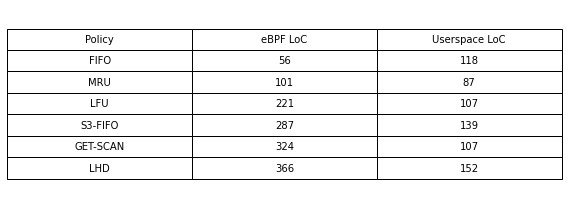

In [49]:
# Lines of code required for each policy

def c_file_is_loc(line: str):
    line = line.strip()
    if line.startswith("//") or line.startswith("/*") or line == "":
        return False
    return True

def c_file_count_loc(file_path: str):
    if not file_path.endswith(".c"):
        raise ValueError("File must be a C file")
    with open(file_path, "r") as f:
        lines = f.readlines()
    loc_count = 0
    for line in lines:
        if c_file_is_loc(line):
            loc_count += 1
    return loc_count

mru_loc_count = c_file_count_loc("page_cache_ext_mru.bpf.c")
lfu_loc_count = c_file_count_loc("page_cache_ext_sampling.bpf.c")
get_scan_loc_count = c_file_count_loc("page_cache_ext_get_scan.bpf.c")
lhd_loc_count = c_file_count_loc("cache_ext_lhd.bpf.c")
s3fifo_loc_count = c_file_count_loc("cache_ext_s3fifo.bpf.c")
fifo_loc_count = c_file_count_loc("cache_ext_fifo.bpf.c")

mru_user_loc_count = c_file_count_loc("page_cache_ext_mru.c")
lfu_user_loc_count = c_file_count_loc("page_cache_ext_sampling.c")
get_user_scan_loc_count = c_file_count_loc("page_cache_ext_get_scan.c")
lhd_user_loc_count = c_file_count_loc("cache_ext_lhd.c")
s3fifo_user_loc_count = c_file_count_loc("cache_ext_s3fifo.c")
fifo_user_loc_count = c_file_count_loc("cache_ext_fifo.c")

# Put the LOC data in a table
table_data = [
    ["MRU", mru_loc_count, mru_user_loc_count],
    ["LFU", lfu_loc_count, lfu_user_loc_count],
    ["GET-SCAN", get_scan_loc_count, get_user_scan_loc_count],
    ["LHD", lhd_loc_count, lhd_user_loc_count],
    ["S3-FIFO", s3fifo_loc_count, s3fifo_user_loc_count],
    ["FIFO", fifo_loc_count, fifo_user_loc_count],
]

# Sort by LOC count
table_data.sort(key=lambda x: x[1])
#table_data_userspace.sort(key=lambda x: x[1])

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(cellText=table_data,
                  colLabels=["Policy", "eBPF LoC", "Userspace LoC"],
                  cellLoc="center",
                  loc="center")

table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# Create a dataframe for the same table
df = pd.DataFrame(table_data, columns=["Policy", "eBPF LoC", "Userspace LoC"])
df.to_latex(FIGURES_DIR + "loc_table.tex", index=False,
            caption="Lines of code required for each policy presented.",
            label="tab:loc-per-policy")


In [52]:
# Kernel lines of code

verifier = 1 + 3 + 86
core_cache_ext = 105 + 57 + 27 + 156 + 235
kfuncs = 748
page_cache = 26 + 8 + 175
cgroup = 80
per_cgroup = 5 + 3 + 1 + 6 + 200 + 3
libbpf = 73

print("Verifier: %d" % verifier)
print("Core Cache Ext: %d" % core_cache_ext)
print("Kfuncs: %d" % kfuncs)
print("Page Cache: %d" % page_cache)
print("Cgroup: %d" % cgroup)
print("Per Cgroup: %d" % per_cgroup)
print("Libbpf: %d" % libbpf)

total = verifier + core_cache_ext + kfuncs + page_cache + cgroup + per_cgroup + libbpf
print("Total: %d" % total)

Verifier: 90
Core Cache Ext: 580
Kfuncs: 748
Page Cache: 209
Cgroup: 80
Per Cgroup: 218
Libbpf: 73
Total: 1998


## FIO Microbenchmark

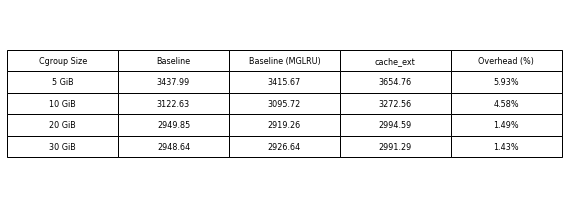

In [8]:
# Plot fio results

baseline_fio_results = bench_lib.parse_results_file("baseline_fio_results.json", bench_lib.BenchResults)
baseline_mglru_fio_results = bench_lib.parse_results_file("baseline_mglru_fio_results.json", bench_lib.BenchResults)
cache_ext_fio_results = bench_lib.parse_results_file("cache_ext_fio_results.json", bench_lib.BenchResults)

add_config_field(baseline_fio_results, "mglru", False)
add_config_field(baseline_mglru_fio_results, "mglru", True)
add_config_field(cache_ext_fio_results, "mglru", False)

cache_ext_fio_results = filter_cache_ext_results(cache_ext_fio_results)
fio_results = baseline_fio_results + cache_ext_fio_results + baseline_mglru_fio_results

cgroup_size = 30 * GiB
cgroup_sizes = [5 * GiB, 10 * GiB, 20 * GiB, 30 * GiB]

baseline_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "baseline_test",
    "mglru": False,
}

baseline_mglru_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "baseline_test",
    "mglru": True,
}

cache_ext_config_match = {
    "name": "fio_benchmark",
    "workload": "randread",
    "cgroup_name": "cache_ext_test",
    "mglru": False,
}

cpu_usage_per_iop_select_fn = lambda r: r["cpu_usage"] / iops_select_fn(r)

baseline_cpu_usage = {}
baseline_mglru_cpu_usage = {}
cache_ext_cpu_usage = {}
cpu_usage_diff = {}
for cgroup_size in cgroup_sizes:
    baseline_config_match["cgroup_size"] = cgroup_size
    baseline_cpu = plot_lib.results_select(fio_results, baseline_config_match, cpu_usage_per_iop_select_fn)
    baseline_cpu_usage[cgroup_size] = np.mean(baseline_cpu) * 10**6

    baseline_mglru_config_match["cgroup_size"] = cgroup_size
    baseline_mglru_cpu = plot_lib.results_select(fio_results, baseline_mglru_config_match, cpu_usage_per_iop_select_fn)
    baseline_mglru_cpu_usage[cgroup_size] = np.mean(baseline_mglru_cpu) * 10**6

    cache_ext_config_match["cgroup_size"] = cgroup_size
    cache_ext_cpu = plot_lib.results_select(fio_results, cache_ext_config_match, cpu_usage_per_iop_select_fn)
    cache_ext_cpu_usage[cgroup_size] = np.mean(cache_ext_cpu) * 10**6

    cpu_usage_diff[cgroup_size] = (cache_ext_cpu_usage[cgroup_size] - baseline_cpu_usage[cgroup_size]) / cache_ext_cpu_usage[cgroup_size] * 100

# print(baseline_cpu_usage)

# Put the CPU overhead data in a table
table_data = []

# Add a row for CPU usage
table_data.extend([
    ["5 GiB", f"{baseline_cpu_usage[5*GiB]:.2f}",   f"{baseline_mglru_cpu_usage[5*GiB]:.2f}", f"{cache_ext_cpu_usage[5*GiB]:.2f}", f"{cpu_usage_diff[5*GiB]:.2f}%"],
    ["10 GiB", f"{baseline_cpu_usage[10*GiB]:.2f}", f"{baseline_mglru_cpu_usage[10*GiB]:.2f}", f"{cache_ext_cpu_usage[10*GiB]:.2f}", f"{cpu_usage_diff[10*GiB]:.2f}%"],
    ["20 GiB", f"{baseline_cpu_usage[20*GiB]:.2f}", f"{baseline_mglru_cpu_usage[20*GiB]:.2f}", f"{cache_ext_cpu_usage[20*GiB]:.2f}", f"{cpu_usage_diff[20*GiB]:.2f}%"],
    ["30 GiB", f"{baseline_cpu_usage[30*GiB]:.2f}", f"{baseline_mglru_cpu_usage[30*GiB]:.2f}", f"{cache_ext_cpu_usage[30*GiB]:.2f}", f"{cpu_usage_diff[30*GiB]:.2f}%"],
])

# Create the table
fig = plt.figure(figsize=(8, 3))
table = plt.table(cellText=table_data,
                  colLabels=["Cgroup Size", "Baseline", "Baseline (MGLRU)", SYS_NAME, "Overhead (%)"],
                  cellLoc="center",
                  loc="center")
table.scale(1, 1.5)
plt.axis("off")
plt.tight_layout()
plt.show()

# Create a dataframe for the same table
df = pd.DataFrame(table_data, columns=["Cgroup Size", "Baseline", "Baseline (MGLRU)", SYS_NAME, "Overhead (%)"])
df.to_latex(FIGURES_DIR + "cpu_overhead_table.tex", index=False,
            caption="fio microbenchmark results to measure CPU overhead of \name per IO operation.",
            label="tab:eval-cpu-overhead",)


In [17]:
google_io_trace_results = bench_lib.parse_results_file("io_trace_results.json", bench_lib.BenchResults)

config_matches = [
    {
        "name": "iotrace_benchmark",
        "iteration": 1,
    }
]

config_matches = bench_lib.add_config_option("cgroup_size", [5 * GiB, 10 * GiB], config_matches)
config_matches = bench_lib.add_config_option("cgroup_name", [bench_lib.DEFAULT_BASELINE_CGROUP, bench_lib.DEFAULT_CACHE_EXT_CGROUP], config_matches)


plot_lib.bench_plot_groupped_results(
    config_matches,
    google_io_trace_results,
    colors=["salmon", "maroon", "limegreen", "olivedrab"],
    bench_types=["trace_cluster1_16TB_20240115_data-00000-of-00100"],
    filename="leveldb_ycsb_results.pdf",
    bar_width=0.3,
)

{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 5368709120, 'cgroup_name': 'baseline_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[432.71]
{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 5368709120, 'cgroup_name': 'cache_ext_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[914.49]
{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'baseline_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[52.77]
{'name': 'iotrace_benchmark', 'iteration': 1, 'cgroup_size': 10737418240, 'cgroup_name': 'cache_ext_test', 'benchmark': 'trace_cluster1_16TB_20240115_data-00000-of-00100'}
[46.1]
[[432.71], [914.49], [52.77], [46.1]]
['Baseline', 'cache_ext', 'Baseline', 'cache_ext']
[-0.45 -0.15  0.15  0.45]
[-0.45]
[-0.15]
[0.15]
[0.45]


<Figure size 432x288 with 0 Axes>

## Per-Cgroup Experiment

[(5570.753333333334, 68.0), (7864.686666666667, 84.0), (2233.3333333333335, 116.0), (8343.94, 122.0)]
Split configuration throughput improvement over baseline: 49.78%
Split configuration RG iters improvement over baseline: 79.41%


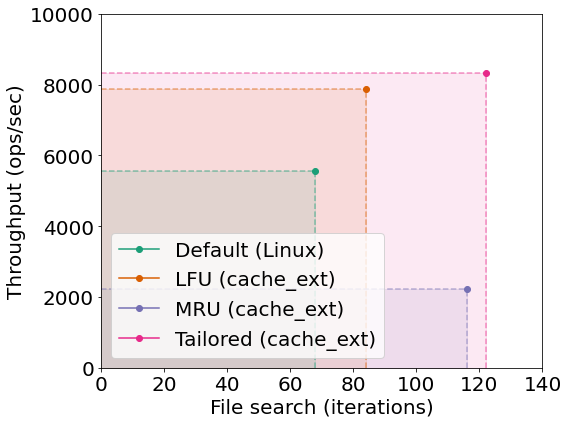

In [3]:
baseline_results = bench_lib.parse_results_file("results/per_cgroup_baseline_results.json", bench_lib.BenchResults)
both_lfu_results = bench_lib.parse_results_file("results/per_cgroup_both_lfu_results.json", bench_lib.BenchResults)
both_mru_results = bench_lib.parse_results_file("results/per_cgroup_both_mru_results.json", bench_lib.BenchResults)
split_results = bench_lib.parse_results_file("results/per_cgroup_split_results.json", bench_lib.BenchResults)

print(baseline_results[0].results)

# Compute the average of the results["throughput_avg"] and results["rg_iters"] fields for each set of results
def avg_throughput_and_rg_iters(results):
    throughput_avg = np.mean([r.results["throughput_avg"] for r in results])
    rg_iters = np.mean([r.results["rg_iters"] for r in results])
    return throughput_avg, rg_iters

labels = ["Default (Linux)", "LFU (cache_ext)", "MRU (cache_ext)", "Tailored (cache_ext)"]
results = [baseline_results, both_lfu_results, both_mru_results, split_results]
avg_throughputs_and_iters = [avg_throughput_and_rg_iters(r) for r in results]
print(avg_throughputs_and_iters)

colors = plt.colormaps['Dark2'].colors[:4]

# Create a point plot using matplotlib, with throughput on the y-axis and RG iters on the x-axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the throughput and RG iters for each set of results
for i in range(len(results)):
    # Use colors from colors list
    ax.plot(avg_throughputs_and_iters[i][1], avg_throughputs_and_iters[i][0], marker="o", color=colors[i], label=labels[i])

# Add dotted lines to each of the points from the x axis and y axis using appropriate colors
# Trim the lines after each point
for i in range(len(results)):
    ax.plot([0, avg_throughputs_and_iters[i][1]], [avg_throughputs_and_iters[i][0], avg_throughputs_and_iters[i][0]], linestyle="--", color=colors[i], alpha=0.5)
    ax.plot([avg_throughputs_and_iters[i][1], avg_throughputs_and_iters[i][1]], [0, avg_throughputs_and_iters[i][0]], linestyle="--", color=colors[i], alpha=0.5)

# Fill in the rectangles created by the lines in reverse order
for i in range(len(results) - 1, -1, -1):
    ax.fill_between([0, avg_throughputs_and_iters[i][1]], 0, avg_throughputs_and_iters[i][0], color=colors[i], alpha=0.1)

# Set x-axis and y-axis to start at 0
ax.set_xlim(left=0, right=140)
ax.set_ylim(bottom=0, top=10000)

# Set tick fontsize
ax.tick_params(axis='both', which='major', labelsize=20)

# Add labels
ax.set_xlabel("File search (iterations)", fontsize=20)
ax.set_ylabel("Throughput (ops/sec)", fontsize=20)

# Add a legend
ax.legend(loc='best', fontsize=20)

# Save to PDF
plt.tight_layout()
plt.savefig(FIGURES_DIR + "per_cgroup.pdf")

# Print percent improvement of split configuration over baseline
baseline_throughput = avg_throughputs_and_iters[0][0]
split_throughput = avg_throughputs_and_iters[3][0]
improvement = (split_throughput - baseline_throughput) / baseline_throughput * 100
print(f"Split configuration throughput improvement over baseline: {improvement:.2f}%")

baseline_iters = avg_throughputs_and_iters[0][1]
split_iters = avg_throughputs_and_iters[3][1]
improvement = (split_iters - baseline_iters) / baseline_iters * 100
print(f"Split configuration RG iters improvement over baseline: {improvement:.2f}%")

# add_config_field(baseline_results, "type", 1)
# add_config_field(both_lfu_results, "type", 2)
# add_config_field(both_mru_results, "type", 3)
# add_config_field(split_results, "type", 4)

# results = baseline_results + both_lfu_results + both_mru_results + split_results